In [44]:
%matplotlib inline
import numpy as np
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pandas as pd
import sklearn.linear_model as lm

In [58]:
training['age'] = training['age'].fillna(0)

In [98]:
training = balanced
clf = lm.LogisticRegression()
clf.fit(training[['age']], training['diabetes_mellitus'])
test['diabetes_mellitus']=clf.predict(test[['age']])

In [79]:
training[['age', 'diabetes_mellitus']]

,age,diabetes_mellitus
1,68.0,1
2,77.0,1
3,25.0,0
4,81.0,0
5,19.0,0
...,...,...
130153,50.0,0
130154,79.0,0
130155,73.0,1
130156,81.0,0


In [89]:
training['age'][training['diabetes_mellitus']==1]

1         68.0
2         77.0
6         67.0
7         59.0
16        78.0
          ... 
130138    78.0
130141    77.0
130143    59.0
130149    51.0
130155    73.0
Name: age, Length: 28151, dtype: float64

In [92]:
has_diabetes = training[training['diabetes_mellitus']==1].sample(25000)
no_diabetes = training[training['diabetes_mellitus']==0].sample(25000)

In [96]:
balanced = pd.concat([has_diabetes,no_diabetes])

In [97]:
balanced

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,...,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
30428,178441,79,75.0,25.180785,0,Caucasian,M,176.00,Emergency Department,Accident & Emergency,...,95.555556,95.555556,0,0,0,0,0,0,0,1
93927,217746,172,66.0,67.814990,0,Caucasian,M,195.59,NaN,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,1
39637,202034,62,57.0,49.159862,1,Caucasian,F,165.10,Recovery Room,Operating Room / Recovery,...,NaN,NaN,0,0,0,0,0,0,0,1
102165,262100,45,49.0,30.520019,0,Caucasian,M,167.60,Floor,Floor,...,NaN,NaN,0,0,0,0,0,0,0,1
89594,149813,36,71.0,34.859052,1,Caucasian,M,175.20,Operating Room,Operating Room / Recovery,...,NaN,NaN,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21666,198216,32,46.0,31.405613,0,African American,M,188.00,NaN,Accident & Emergency,...,250.000000,250.000000,0,0,0,0,0,0,0,0
55639,277657,194,60.0,20.246914,0,African American,M,180.00,Direct Admit,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,0
109926,227798,58,88.0,23.809513,0,Caucasian,F,149.90,NaN,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,0
125936,257292,127,83.0,26.546030,0,Caucasian,M,183.00,Floor,Floor,...,NaN,NaN,0,0,0,0,0,0,0,0


(array([ 4355.,   240.,  4310.,  5421.,  6840., 12293., 17893., 19337.,
        17569., 13748.]),
 array([ 0. ,  8.9, 17.8, 26.7, 35.6, 44.5, 53.4, 62.3, 71.2, 80.1, 89. ]),
 <BarContainer object of 10 artists>)

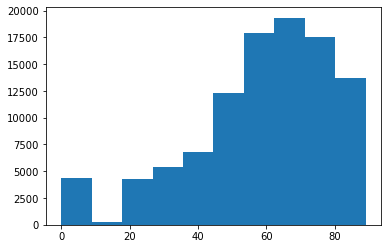

In [85]:
plt.hist(training['age'][training['diabetes_mellitus']==0])

(array([ 663.,   25.,  538.,  725., 1246., 2902., 5327., 7105., 6198.,
        3422.]),
 array([ 0. ,  8.9, 17.8, 26.7, 35.6, 44.5, 53.4, 62.3, 71.2, 80.1, 89. ]),
 <BarContainer object of 10 artists>)

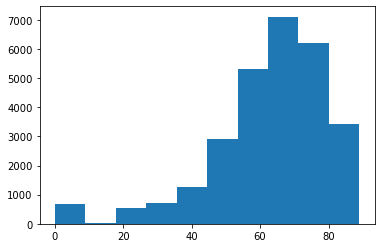

In [86]:
plt.hist(training['age'][training['diabetes_mellitus']==1])

In [99]:
# plot logistic regression model
plt.figure(1, figsize=(4, 3))
plt.clf()
X_test = np.linspace(0, 120, 300)

<Figure size 288x216 with 0 Axes>

In [100]:
clf.predict(X_test[:,None])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], d

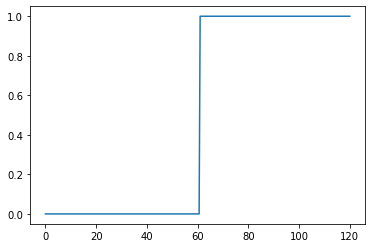

In [101]:
plt.plot(X_test, clf.predict(X_test[:,None]))

In [64]:
test

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,...,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
1,144740,10141,72,NaN,0,Caucasian,F,152.4,Floor,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,0
2,141990,10141,86,NaN,0,Caucasian,F,175.3,Emergency Department,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,0
3,142038,10141,72,NaN,0,Caucasian,F,162.6,Floor,Floor,...,NaN,NaN,0,0,0,0,0,0,0,0
4,138628,10141,66,NaN,0,Caucasian,M,177.8,Floor,Floor,...,NaN,NaN,0,0,0,0,0,0,0,0
5,141682,10141,89,NaN,0,Caucasian,M,170.2,Direct Admit,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10230,143750,10140,36,37.5,0,Caucasian,F,170.1,Floor,Floor,...,NaN,NaN,0,0,0,0,0,0,0,0
10231,143813,10140,61,32.1,0,Caucasian,F,160.0,Emergency Department,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,0
10232,137126,10140,74,22.7,0,Caucasian,F,165.1,Step-Down Unit (SDU),Floor,...,NaN,NaN,0,0,0,0,0,0,0,0
10233,135652,10140,90,19.9,0,Caucasian,F,160.0,Emergency Department,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,0


In [60]:
test.age

1        72
2        86
3        72
4        66
5        89
         ..
10230    36
10231    61
10232    74
10233    90
10234    30
Name: age, Length: 10234, dtype: int64

In [17]:
test = pd.read_csv('Data/UnlabeledWiDS2021.csv', index_col=0)
test

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,...,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
1,144740,10141,72,NaN,0,Caucasian,F,152.4,Floor,Accident & Emergency,...,NaN,NaN,NaN,0,0,0,0,0,0,0
2,141990,10141,86,NaN,0,Caucasian,F,175.3,Emergency Department,Accident & Emergency,...,NaN,NaN,NaN,0,0,0,0,0,0,0
3,142038,10141,72,NaN,0,Caucasian,F,162.6,Floor,Floor,...,NaN,NaN,NaN,0,0,0,0,0,0,0
4,138628,10141,66,NaN,0,Caucasian,M,177.8,Floor,Floor,...,NaN,NaN,NaN,0,0,0,0,0,0,0
5,141682,10141,89,NaN,0,Caucasian,M,170.2,Direct Admit,Accident & Emergency,...,NaN,NaN,NaN,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10230,143750,10140,36,37.5,0,Caucasian,F,170.1,Floor,Floor,...,NaN,NaN,NaN,0,0,0,0,0,0,0
10231,143813,10140,61,32.1,0,Caucasian,F,160.0,Emergency Department,Accident & Emergency,...,NaN,NaN,NaN,0,0,0,0,0,0,0
10232,137126,10140,74,22.7,0,Caucasian,F,165.1,Step-Down Unit (SDU),Floor,...,NaN,NaN,NaN,0,0,0,0,0,0,0
10233,135652,10140,90,19.9,0,Caucasian,F,160.0,Emergency Department,Accident & Emergency,...,NaN,NaN,NaN,0,0,0,0,0,0,0


In [20]:
test['diabetes_mellitus']=test['elective_surgery']
test

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,...,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
1,144740,10141,72,NaN,0,Caucasian,F,152.4,Floor,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,0
2,141990,10141,86,NaN,0,Caucasian,F,175.3,Emergency Department,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,0
3,142038,10141,72,NaN,0,Caucasian,F,162.6,Floor,Floor,...,NaN,NaN,0,0,0,0,0,0,0,0
4,138628,10141,66,NaN,0,Caucasian,M,177.8,Floor,Floor,...,NaN,NaN,0,0,0,0,0,0,0,0
5,141682,10141,89,NaN,0,Caucasian,M,170.2,Direct Admit,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10230,143750,10140,36,37.5,0,Caucasian,F,170.1,Floor,Floor,...,NaN,NaN,0,0,0,0,0,0,0,0
10231,143813,10140,61,32.1,0,Caucasian,F,160.0,Emergency Department,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,0
10232,137126,10140,74,22.7,0,Caucasian,F,165.1,Step-Down Unit (SDU),Floor,...,NaN,NaN,0,0,0,0,0,0,0,0
10233,135652,10140,90,19.9,0,Caucasian,F,160.0,Emergency Department,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,0


In [103]:
results = test[['encounter_id','diabetes_mellitus']].set_index('encounter_id')
results.to_csv('Data/results.csv')

In [41]:
training = pd.read_csv('Data/TrainingWiDS2021.csv', index_col=0)
training['age']

1         68.0
2         77.0
3         25.0
4         81.0
5         19.0
          ... 
130153    50.0
130154    79.0
130155    73.0
130156    81.0
130157    35.0
Name: age, Length: 130157, dtype: float64

In [11]:
solution = pd.read_csv('Data/SolutionTemplateWiDS2021.csv',index_col=0)
solution

,diabetes_mellitus
encounter_id,
135000,NaN
135001,NaN
135002,NaN
135003,NaN
135004,NaN
...,...
145996,NaN
145997,NaN
145998,NaN


In [12]:
solution['diabetes_mellitus']=0

In [15]:
solution.to_csv('Data/results.csv')

In [14]:
solution.diabetes_mellitus

encounter_id
135000    0
135001    0
135002    0
135003    0
135004    0
         ..
145996    0
145997    0
145998    0
145999    0
146000    0
Name: diabetes_mellitus, Length: 10234, dtype: int64

# Age + BMI logistic regression

In [111]:
balanced['bmi'] = pd.to_numeric(balanced['bmi'])

In [113]:
balanced['bmi']

30428     25.180785
93927     67.814990
39637     49.159862
102165    30.520019
89594     34.859052
            ...    
21666     31.405613
55639     20.246914
109926    23.809513
125936    26.546030
9121      39.046300
Name: bmi, Length: 50000, dtype: float64

In [114]:
test['bmi'] = pd.to_numeric(test['bmi'])

In [117]:
balanced['bmi'] = balanced['bmi'].fillna(0)
test['bmi'] = test['bmi'].fillna(0)

In [118]:
clf2 = lm.LogisticRegression()
clf2.fit(training[['age','bmi']], training['diabetes_mellitus'])
test['diabetes_mellitus']=clf2.predict(test[['age','bmi']])

In [119]:
results = test[['encounter_id','diabetes_mellitus']].set_index('encounter_id')
results.to_csv('Data/results.csv')

# Age + BMI kNN classifier

In [120]:
import sklearn.neighbors as nb

In [121]:
clf3 = nb.KNeighborsClassifier()
clf3.fit(training[['age','bmi']], training['diabetes_mellitus'])
test['diabetes_mellitus']=clf3.predict(test[['age','bmi']])

In [123]:
results = test[['encounter_id','diabetes_mellitus']].set_index('encounter_id')
results.to_csv('Data/results.csv')

# Age, BMI, Glucose Apache kNN

In [125]:
balanced['glucose_apache'] = balanced['glucose_apache'].fillna(0)
test['glucose_apache'] = test['glucose_apache'].fillna(0)

In [126]:
clf3 = nb.KNeighborsClassifier()
clf3.fit(training[['age','bmi','glucose_apache']], training['diabetes_mellitus'])
test['diabetes_mellitus']=clf3.predict(test[['age','bmi','glucose_apache']])

In [127]:
results = test[['encounter_id','diabetes_mellitus']].set_index('encounter_id')
results.to_csv('Data/results.csv')

# Age, BMI, Glucose Apache logistic regression

In [128]:
clf2 = lm.LogisticRegression()
clf2.fit(training[['age','bmi','glucose_apache']], training['diabetes_mellitus'])
test['diabetes_mellitus']=clf2.predict(test[['age','bmi','glucose_apache']])

In [129]:
results = test[['encounter_id','diabetes_mellitus']].set_index('encounter_id')
results.to_csv('Data/results.csv')

# Decision Tree

In [138]:
import sklearn.tree as tree
import sklearn.preprocessing as pp

In [131]:
clf = tree.DecisionTreeClassifier()
clf.fit(training[['age','bmi','glucose_apache']], training['diabetes_mellitus'])
test['diabetes_mellitus']=clf.predict(test[['age','bmi','glucose_apache']])

In [132]:
results = test[['encounter_id','diabetes_mellitus']].set_index('encounter_id')
results.to_csv('Data/results.csv')

In [135]:
trainingX = training.drop(columns=['diabetes_mellitus'])
testX = test.drop(columns=['diabetes_mellitus'])

In [141]:
training['ethnicity'] = training['ethnicity'].fillna("Missing")
test['ethnicity'] = test['ethnicity'].fillna("Missing")

In [148]:
enc = pp.OneHotEncoder()
training['ethnicity']=enc.fit_transform(training[['ethnicity']]).toarray()

AttributeError: 'bool' object has no attribute 'any'

In [147]:
training

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,...,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
30428,178441,79,75.0,25.180785,0,"(0, 2)\t1.0\n (1, 2)\t1.0\n (2, 2)\t1.0\n ...",M,176.00,Emergency Department,Accident & Emergency,...,95.555556,95.555556,0,0,0,0,0,0,0,1
93927,217746,172,66.0,67.814990,0,"(0, 2)\t1.0\n (1, 2)\t1.0\n (2, 2)\t1.0\n ...",M,195.59,NaN,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,1
39637,202034,62,57.0,49.159862,1,"(0, 2)\t1.0\n (1, 2)\t1.0\n (2, 2)\t1.0\n ...",F,165.10,Recovery Room,Operating Room / Recovery,...,NaN,NaN,0,0,0,0,0,0,0,1
102165,262100,45,49.0,30.520019,0,"(0, 2)\t1.0\n (1, 2)\t1.0\n (2, 2)\t1.0\n ...",M,167.60,Floor,Floor,...,NaN,NaN,0,0,0,0,0,0,0,1
89594,149813,36,71.0,34.859052,1,"(0, 2)\t1.0\n (1, 2)\t1.0\n (2, 2)\t1.0\n ...",M,175.20,Operating Room,Operating Room / Recovery,...,NaN,NaN,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21666,198216,32,46.0,31.405613,0,"(0, 2)\t1.0\n (1, 2)\t1.0\n (2, 2)\t1.0\n ...",M,188.00,NaN,Accident & Emergency,...,250.000000,250.000000,0,0,0,0,0,0,0,0
55639,277657,194,60.0,20.246914,0,"(0, 2)\t1.0\n (1, 2)\t1.0\n (2, 2)\t1.0\n ...",M,180.00,Direct Admit,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,0
109926,227798,58,88.0,23.809513,0,"(0, 2)\t1.0\n (1, 2)\t1.0\n (2, 2)\t1.0\n ...",F,149.90,NaN,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,0
125936,257292,127,83.0,26.546030,0,"(0, 2)\t1.0\n (1, 2)\t1.0\n (2, 2)\t1.0\n ...",M,183.00,Floor,Floor,...,NaN,NaN,0,0,0,0,0,0,0,0


In [137]:
clf.fit(trainingX, training['diabetes_mellitus'])
test['diabetes_mellitus']=clf.predict(testX)

ValueError: could not convert string to float: 'Caucasian'